### A notebook to build a network of climate change expert profiles 

#### Created for  @IsThisAnExpert, winner project of the Goethe's Institute [ClimateChange Hackaton](https://www.goethe.de/en/uun/pub/akt/22026559.html)

This notebook uses the Twitter API to retrieve [friends](https://developer.twitter.com/en/docs/twitter-api/v1/accounts-and-users/follow-search-get-users/api-reference/get-friends-ids) lists from twitter profiles of climate experts  from a manually curated selection.

The lists of climate expert friends are then parsed to find the most followed twitter handles among the experts.

A `CSV` file will be generated with a list of twitter handles shared among the experts, the count of how many experts follow that account and whether it has already been included in the **@IsThisAnExpert** curated list.

The `CSV` file needs then to be manually reviewed and cross-referenced with additional information such as origin of the twitter handles, type of user, user afiliations and so on, to discover experts that will be included in the **credibility-score assesment algorithm** of @IsThisAnExpert


In [3]:
#!/usr/bin/env python3.7
import tweepy
import sys
import os, json
import pandas as pd
import subprocess
from collections import Counter
import time
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
# load environment variables
load_dotenv()

# Setup API:
def twitter_setup():
    # Authenticate and access using keys:
    auth = tweepy.OAuthHandler(os.getenv('CONSUMER_KEY'), os.getenv('CONSUMER_SECRET'))
    auth.set_access_token(os.getenv('ACCESS_TOKEN'), os.getenv('ACCESS_SECRET'))
    auth.secure = True
    # Return API access:
    # use wait_on_rate_limit to avoid getting banned
    api = tweepy.API(auth, wait_on_rate_limit=True,wait_on_rate_limit_notify=True)
    return api



def get_user_network(user_id):
    
    ## function adapted from https://vasisouv.github.io/twitter-api-tutorial/tutorial.html

    print("Searching network for user with id " + str(user_id))

    friends = []
    max_friends = 100000
        
    try:

        for page in tweepy.Cursor(api.friends_ids, screen_name=user_id).pages():
            friends.extend(page)
            if len(friends) >= max_friends:
                break
            print("Friends so far : " + str(len(friends)))
        print("finished friends")
    except tweepy.TweepError as tweep_error:
        print("Error with code : " + str(tweep_error.response.text))
        return 0
    print("User with ID: " + user_id + " has " + str(len(friends)) + " friends")

    custom_object = {
        user_id: friends
    }
    return custom_object

# set api entry point
api = twitter_setup()

# open csv file with the twitter handles
twitter_handles = pd.read_csv('/home/franasa/Downloads/TwitterHandles.csv')
handles_list=twitter_handles.TwitterHandle.tolist()
#create a dictionary to store user:user's friends
user_dict={}

######### uncomment these lines to save the query results as a json file ############
    
# with open('user_friends.json', 'r') as fil:
#     friends_json = json.load(fil)
    

# for user_name in handles_list:    
#     if not user_name in friends_json:
#         friends_json[user_name]=get_user_network(user_name)
#         with open('user_friends.json', 'w') as fil:
#             json.dump(friends_json, fil)


In [4]:
## open the json file 
with open('user_friends.json', 'r') as fil:
    friends_json = json.load(fil)
    
## dirty fix dictionary to put everything at the same level and ignore missing handles
fix_dict={}
for user_name in friends_json:
    if type(friends_json[user_name])==list:
        fix_dict[user_name]={'friends_list': friends_json[user_name]}

    elif type(friends_json[user_name])==dict:

        fix_dict[user_name]={'friends_list': friends_json[user_name][user_name]}
    else:
        print(user_name, friends_json[user_name])

# ad to the dictionary the numeric user identifiers
for x in fix_dict:
    # fetching the user 
    user = api.get_user(x) 
    fix_dict[x]['id']= user.id_str 


@dr_nerilie 0


#### Calculate the number of experts following a profile

In [15]:
## get friends numeric ids 
user_ids=[fix_dict[x]['id'] for x in fix_dict]
## get list of lists of friends for all parsed experts
friends_list = [fix_dict[x]['friends_list'] for x in fix_dict if fix_dict[x]['friends_list']]

## start the counter
counter = Counter(friends_list[0])
for i in friends_list[1:]: 
    counter.update(i)

# filter friends that are shared by at least 20 experts
shared_friends=[x for x in counter.most_common() if x[1] >20]

print(f"found {len(shared_friends)} profiles shared by at least 20 experts")

# prepare the dictionary to create the CSV file
dicto_df={}
# set index
count=0
for friend in shared_friends:
    user = api.get_user(friend[0]) 
    count+=1
    
    if str(friend[0]) in user_ids:
        indb=True
    else: indb=False
#     fix_dict[x]['id']= user.screen_name 
    dicto_df[count]={
        'friend_screen_name': user.screen_name ,
        'friend_id': friend[0],
        'appereance_count': friend[1],
        'in_database': indb ## is this an expert from the manually curated database
    }

found 269 profiles shared by at least 20 experts


In [16]:
## save the networking dataframe to a CSV file
shared_climate_friends=pd.DataFrame.from_dict(dicto_df, orient='index')
shared_climate_friends.to_csv("shared_climate_friends.csv", index=False)

shared_climate_friends

# shared_climate_friends[shared_climate_friends['in_database']==True].head(15)

,friend_screen_name,friend_id,appereance_count,in_database
1,IPCC_CH,192942213,64,True
2,UNFCCC,17463923,61,True
3,GretaThunberg,1006419421244678144,59,False
4,guardianeco,20582958,59,False
5,KHayhoe,34317032,57,True
...,...,...,...,...
265,BAS_News,229045433,21,True
266,PEspinosaC,214842351,21,True
267,guardiannews,788524,21,False
268,smithsonian,14199378,21,False


Text(0, 0.5, 'Expert profile')

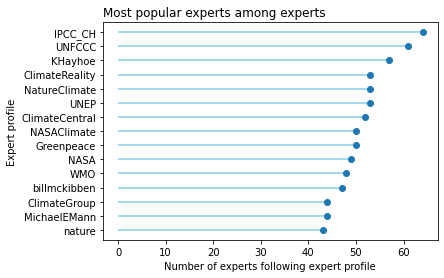

In [17]:
## make two info plots

# Create a dataframe
df =shared_climate_friends[shared_climate_friends['in_database']==True].head(15)
# Reorder it following the values:
ordered_df = df.sort_values(by='appereance_count')
my_range=range(1,len(df.index)+1)
 
# The vertival plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['appereance_count'], color='skyblue')
plt.plot(ordered_df['appereance_count'], my_range, "o")
 
# Add titles and axis names
plt.yticks(my_range, ordered_df['friend_screen_name'])
plt.title("Most popular experts among experts", loc='left')
plt.xlabel('Number of experts following expert profile')
plt.ylabel('Expert profile')


Text(0, 0.5, 'Twitter Profile')

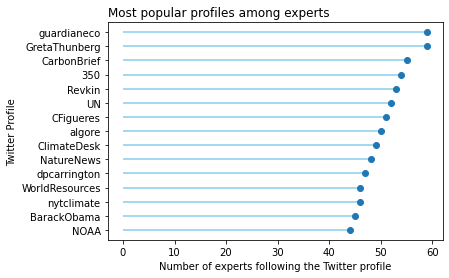

In [18]:
# Create a dataframe
df =shared_climate_friends[shared_climate_friends['in_database']==False].head(15)
# Reorder it following the values:
ordered_df = df.sort_values(by='appereance_count')
my_range=range(1,len(df.index)+1)
 
# The vertival plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['appereance_count'], color='skyblue')
plt.plot(ordered_df['appereance_count'], my_range, "o")
 
# Add titles and axis names
plt.yticks(my_range, ordered_df['friend_screen_name'])
plt.title("Most popular profiles among experts", loc='left')
plt.xlabel('Number of experts following the Twitter profile')
plt.ylabel('Twitter Profile')
